# Table of Contents

1. [Feature engineering](#1-bullet) <br>
    I - [Number of orders](#2-bullet) <br>
    II - [Customer location](#3-bullet) <br>
    III - [Time of orders](#4-bullet) <br>
    IV - [Products informations](#5-bullet) <br>
    V - [Reviews informations](#6-bullet) <br>
    VI - [Payment informations](#7-bullet) <br>
    <br>
    
2. [Preprocessing](#8-bullet) <br>
    <br>
    
3. [KMeans](#9-bullet) <br>
    I - [First iteration with few key variables](#10-bullet) <br>
    II - [Visualisation and interpretation of clusters](#11-bullet) <br>
    III - [Adding mean_review_score variable](#12-bullet) <br>
    IV - [Adding customer_state variable](#13-bullet) <br>
    <br>
    
4. [DBSCAN](#14-bullet) <br>
    I - [Binary search for eps](#20-bullet) <br>
    II - [Selecting best parameters](#21-bullet) <br>
    III - [Selected model](#22-bullet) <br>
    <br>
    
5. [Agglomerative clustering](#15-bullet) <br>
    I - [Clusters selection](#16-bullet) <br>
    II - [5 clusters](#17-bullet) <br>
    III - [4 clusters](#18-bullet) <br>
    <br>
    
6. [Conclusion](#19-bullet) <br>
    <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import timeit

from functions import *

In [2]:
# Loading datas

customers = pd.read_csv('olist_customers_dataset.csv', sep=',')
geolocation = pd.read_csv('olist_geolocation_dataset.csv', sep=',')
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
orders = pd.read_csv('olist_orders_dataset.csv', sep=',')
products = pd.read_csv('olist_products_dataset.csv', sep=',')
sellers = pd.read_csv('olist_sellers_dataset.csv', sep=',')
product_category_name_translation = pd.read_csv('product_category_name_translation.csv', sep=',')

full_data = pd.read_csv('cleaned_data.csv', sep=',')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_row', 50)

In [4]:
full_data.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,nb_items,total_price,total_freight_value,mean_price,mean_freight_value,prefered_product_category_name,mean_product_name_lenght,mean_product_description_lenght,mean_product_photos_qty,mean_product_weight_g,mean_product_length_cm,mean_product_height_cm,mean_product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,nb_payments,prefered_payment_type,mean_payment_installments,total_payment_value,mean_payment_value,max_payment_value,min_payment_value
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,['a9516a079e37a9c9c36b9b78b10169e8'],['7c67e1448b00f6e969d365cea6b010ab'],2017-05-22 15:22:12,1.0,124.99,21.88,124.99,21.88,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,88b8b52d46df026a9d1ad2136a59b30b,4.0,Not applicable,Not applicable,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,credit_card,2.0,146.87,146.87,146.87,146.87
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,['4aa6014eceb682077f9dc4bffebc05b0'],['b8bc237ba3788b23da09c0f1f3a3288c'],2018-01-18 20:58:32,1.0,289.00,46.48,289.00,46.48,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,Not applicable,Not applicable,2018-01-30 00:00:00,2018-02-10 22:43:29,1.0,credit_card,8.0,335.48,335.48,335.48,335.48
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,['bd07b66896d6f1494f5b86251848ced7'],['7c67e1448b00f6e969d365cea6b010ab'],2018-06-05 16:19:10,1.0,139.94,17.79,139.94,17.79,office_furniture,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,5ad6695d76ee186dc473c42706984d87,5.0,Not applicable,Not applicable,2018-06-15 00:00:00,2018-06-15 12:10:59,1.0,credit_card,7.0,157.73,157.73,157.73,157.73
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,['a5647c44af977b148e0a3a4751a09e2e'],['7c67e1448b00f6e969d365cea6b010ab'],2018-03-27 16:31:16,1.0,149.94,23.36,149.94,23.36,office_furniture,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,059a801bb31f6aab2266e672cab87bc5,5.0,Not applicable,Not applicable,2018-03-29 00:00:00,2018-04-02 18:36:47,1.0,credit_card,1.0,173.30,173.30,173.30,173.30
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,['9391a573abe00141c56e38d84d7d5b3b'],['4a3ca9315b744ce9f8e9374361493884'],2018-07-31 10:10:09,1.0,230.00,22.25,230.00,22.25,home_confort,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,8490879d58d6c5d7773f2739a03f089a,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1.0,credit_card,8.0,252.25,252.25,252.25,252.25


In [5]:
full_data.shape

(99431, 44)

# 1. Feature engineering <a class="anchor" id="1-bullet"></a>

We will create a new dataframe with one row per customer and with a selection of relevant variables

In [6]:
len(full_data['customer_unique_id'].unique())

96086

In [7]:
data = pd.DataFrame()
data['customer_unique_id'] = full_data['customer_unique_id'].unique()

In [8]:
data.shape

(96086, 1)

## I - Number of orders <a class="anchor" id="2-bullet"></a>

In [9]:
temp_df = pd.DataFrame()
temp_df['customer_unique_id'] = full_data['customer_unique_id'].value_counts().index
temp_df['nb_orders'] = full_data['customer_unique_id'].value_counts().values
temp_df

,customer_unique_id,nb_orders
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,6469f99c1f9dfae7733b25662e7f1782,7
3,1b6c7548a2a1f9037c1fd3ddfed95f33,7
4,ca77025e7201e3b30c44b472ff346268,7
...,...,...
96081,5b5c96a57b90dd238dd79f6079021707,1
96082,081f07439678af2da7755a0aa572154d,1
96083,9c57789a6a587f4efcfb01e36c106014,1
96084,9e4c21635f640562de1a6976374fba03,1


In [10]:
# Adding number of orders per customer

# Create df to store the nb_orders per customer_unique_id
temp_df = pd.DataFrame()
temp_df['customer_unique_id'] = full_data['customer_unique_id'].value_counts().index
temp_df['nb_orders'] = full_data['customer_unique_id'].value_counts().values

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders
0,861eff4711a542e4b93843c6dd7febb0,1
1,290c77bc529b7ac935b93aa66c333dc3,1
2,060e732b5b29e8181a18229c7b0b2b5e,1
3,259dac757896d24d7702b9acbbff3f3c,1
4,345ecd01c38d18a9036ed96c73b8d066,1


In [11]:
data.shape

(96086, 2)

In [12]:
data[data['customer_unique_id'] == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,nb_orders
14101,8d50f5eadf50201ccdcedfb9e2ac8455,17


## II - Customer location <a class="anchor" id="3-bullet"></a>

In [13]:
# Location informations : we will keep only customer_state and coordinates, city will creates too many values

var_list = ['customer_unique_id', 'customer_state', 'customer_geolocation_lat', 'customer_geolocation_lng']

# Creating df to store our variables
temp_df = pd.DataFrame()

for var in var_list:
    temp_df[var] = full_data.drop_duplicates(subset='customer_unique_id')[var]

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925


## III - Time of orders <a class="anchor" id="4-bullet"></a>

In [14]:
# Time of orders : first we get the time of the first and the last order of each customer_unique_id

# Creating df to store our variables
temp_df = pd.DataFrame()
temp_df['last_order_time'] = full_data.groupby(by='customer_unique_id')['order_purchase_timestamp'].max()
temp_df['first_order_time'] = full_data.groupby(by='customer_unique_id')['order_purchase_timestamp'].min()

# Transforming in date type
temp_df['last_order_time'] = pd.to_datetime(temp_df['last_order_time'], infer_datetime_format=True, errors='raise')
temp_df['first_order_time'] = pd.to_datetime(temp_df['first_order_time'], infer_datetime_format=True, errors='raise')

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30


In [15]:
# We will compute the mean time between orders of each customer_unique_id

mean_time_between_orders = [] # The list we will add to our df once completed

for time_list in full_data.groupby(by='customer_unique_id')['order_purchase_timestamp'].apply(list): # Getting all order times of each customer_unique_id in a list
    
    if len(time_list) == 1: # If we have only one order we can't compute a difference
        mean_time_between_orders.append(pd._libs.tslibs.timedeltas.Timedelta(0))
    
    else: # If we have 2 or more orders
        
        time_list = pd.to_datetime(time_list, infer_datetime_format=True, errors='raise').sort_values()
        
        diff_times = [] # For each customer_unique_id we will get times differences between each orders in a list

        for i, elt in enumerate(time_list):
            if i == 0: # For the first order time we can't compute a difference with previous order
                pass
            else: # For the second orders and the nexts we compute the difference with previous order
                diff_times.append(time_list[i] - time_list[i-1])

        mean_time_between_orders.append(np.mean(diff_times)) # We take the mean of times between 2 consecutives orders

len(mean_time_between_orders) # Checking we have the right lenght

96086

In [16]:
# Adding the list to our df
data['mean_time_between_orders'] = mean_time_between_orders
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days


In [17]:
data.dtypes

customer_unique_id                   object
nb_orders                             int64
customer_state                       object
customer_geolocation_lat            float64
customer_geolocation_lng            float64
last_order_time              datetime64[ns]
first_order_time             datetime64[ns]
mean_time_between_orders    timedelta64[ns]
dtype: object

## IV - Products informations <a class="anchor" id="5-bullet"></a>

In [18]:
# Creating df to store our variables
temp_df = pd.DataFrame()

# nb_items
temp_df['total_nb_items'] = full_data.groupby(by='customer_unique_id')['nb_items'].sum()
temp_df['mean_nb_items'] = full_data.groupby(by='customer_unique_id')['nb_items'].mean()

# price and freight
temp_df['mean_price'] = full_data.groupby(by='customer_unique_id')['total_price'].mean()
temp_df['mean_freight_value'] = full_data.groupby(by='customer_unique_id')['total_freight_value'].mean()

# product_category
temp_df['prefered_product_category_name'] = full_data.groupby(by='customer_unique_id')['prefered_product_category_name'].agg(pd.Series.mode)
temp_df['prefered_product_category_name'] = select_one_mode_value(temp_df, 'prefered_product_category_name')

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders,total_nb_items,mean_nb_items,mean_price,mean_freight_value,prefered_product_category_name
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days,1.0,1.0,124.99,21.88,office_furniture
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days,1.0,1.0,289.00,46.48,housewares
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days,1.0,1.0,139.94,17.79,office_furniture
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days,1.0,1.0,149.94,23.36,office_furniture
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days,1.0,1.0,230.00,22.25,home_confort


For now we won't use products characteristics (lenght, weight...), it doesn't seem useful for a clustering

## V - Reviews informations <a class="anchor" id="6-bullet"></a>

In [19]:
# First we create new variables in full_data before aggregation by customer_unique_id

# To know for a given variable if there is a review or not
def has_review(elt):
    if elt == 'Not applicable':
        return 0
    else:
        return 1

# Application of this function
full_data['has_review'] = full_data['review_id'].apply(has_review)
full_data['has_review_comment_title'] = full_data['review_comment_title'].apply(has_review)
full_data['has_review_comment_message'] = full_data['review_comment_message'].apply(has_review)

# Computing time between delivery and review
def time_diff(time_1, time_2):
    if time_1 == 'Not applicable' or time_2 == 'Not applicable': # If no review we set diff to 0
        return pd._libs.tslibs.timedeltas.Timedelta(0)
    else: # If there is a review we compute the diff
        return pd.to_datetime(time_1) - pd.to_datetime(time_2)

full_data['time_for_review'] = full_data.apply(lambda x: time_diff(x['review_answer_timestamp'], x['order_delivered_customer_date']), axis=1)

# Transforming review_score in NaN and float
def to_float(elt):
    if elt == 'Not applicable':
        return np.nan
    else:
        return float(elt)

full_data['review_score'] = full_data['review_score'].apply(to_float)

In [20]:
full_data[['review_score', 'has_review', 'has_review_comment_title', 'has_review_comment_message', 'time_for_review']]

,review_score,has_review,has_review_comment_title,has_review_comment_message,time_for_review
0,4.0,1,0,0,5 days 11:59:05
1,5.0,1,0,0,12 days 10:02:10
2,5.0,1,0,0,0 days 18:12:08
3,5.0,1,0,0,5 days 02:32:22
4,5.0,1,1,1,7 days 05:04:04
...,...,...,...,...,...
99426,4.0,1,1,0,14 days 15:08:27
99427,5.0,1,0,0,4 days 15:41:20
99428,1.0,1,1,1,-2 days +06:37:52
99429,5.0,1,0,0,3 days 03:35:39


In [21]:
# Now we can create our variables

temp_df = pd.DataFrame()

# % reviews
nb_orders = full_data.groupby(by='customer_unique_id')['customer_unique_id'].apply(len)

temp_df['%_review'] = (full_data.groupby(by='customer_unique_id')['has_review'].sum()) / nb_orders
temp_df['%_review_comment_title'] = (full_data.groupby(by='customer_unique_id')['has_review_comment_title'].sum()) / nb_orders
temp_df['%_review_comment_message'] = (full_data.groupby(by='customer_unique_id')['has_review_comment_message'].sum()) / nb_orders

# mean score
temp_df['mean_review_score'] = full_data.groupby(by='customer_unique_id')['review_score'].mean()

# mean review time
temp_df['mean_time_for_review'] = full_data.groupby(by='customer_unique_id')['time_for_review'].mean()

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders,total_nb_items,mean_nb_items,mean_price,mean_freight_value,prefered_product_category_name,%_review,%_review_comment_title,%_review_comment_message,mean_review_score,mean_time_for_review
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days,1.0,1.0,124.99,21.88,office_furniture,1.0,0.0,0.0,4.0,5 days 11:59:05
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days,1.0,1.0,289.00,46.48,housewares,1.0,0.0,0.0,5.0,12 days 10:02:10
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days,1.0,1.0,139.94,17.79,office_furniture,1.0,0.0,0.0,5.0,0 days 18:12:08
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days,1.0,1.0,149.94,23.36,office_furniture,1.0,0.0,0.0,5.0,5 days 02:32:22
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days,1.0,1.0,230.00,22.25,home_confort,1.0,1.0,1.0,5.0,7 days 05:04:04


## VI - Payment informations <a class="anchor" id="7-bullet"></a>

In [22]:
# Creating a df with our variables

temp_df = pd.DataFrame()

# prefered_payment_type
temp_df['prefered_payment_type'] = full_data.groupby(by='customer_unique_id')['prefered_payment_type'].agg(pd.Series.mode)
temp_df['prefered_payment_type'] = select_one_mode_value(temp_df, 'prefered_payment_type')

# payment 
temp_df['total_payment_value'] = full_data.groupby(by='customer_unique_id')['total_payment_value'].sum()
temp_df['mean_payment_value'] = full_data.groupby(by='customer_unique_id')['total_payment_value'].mean()

# Merge
data = pd.merge(data, temp_df, how='left', on='customer_unique_id')
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders,total_nb_items,mean_nb_items,mean_price,mean_freight_value,prefered_product_category_name,%_review,%_review_comment_title,%_review_comment_message,mean_review_score,mean_time_for_review,prefered_payment_type,total_payment_value,mean_payment_value
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days,1.0,1.0,124.99,21.88,office_furniture,1.0,0.0,0.0,4.0,5 days 11:59:05,credit_card,146.87,146.87
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days,1.0,1.0,289.00,46.48,housewares,1.0,0.0,0.0,5.0,12 days 10:02:10,credit_card,335.48,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days,1.0,1.0,139.94,17.79,office_furniture,1.0,0.0,0.0,5.0,0 days 18:12:08,credit_card,157.73,157.73
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days,1.0,1.0,149.94,23.36,office_furniture,1.0,0.0,0.0,5.0,5 days 02:32:22,credit_card,173.30,173.30
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days,1.0,1.0,230.00,22.25,home_confort,1.0,1.0,1.0,5.0,7 days 05:04:04,credit_card,252.25,252.25


In [23]:
data.shape

(96086, 21)

In [24]:
data.dtypes

customer_unique_id                         object
nb_orders                                   int64
customer_state                             object
customer_geolocation_lat                  float64
customer_geolocation_lng                  float64
last_order_time                    datetime64[ns]
first_order_time                   datetime64[ns]
mean_time_between_orders          timedelta64[ns]
total_nb_items                            float64
mean_nb_items                             float64
mean_price                                float64
mean_freight_value                        float64
prefered_product_category_name             object
%_review                                  float64
%_review_comment_title                    float64
%_review_comment_message                  float64
mean_review_score                         float64
mean_time_for_review              timedelta64[ns]
prefered_payment_type                      object
total_payment_value                       float64


In [25]:
data[data.columns[data.isnull().any()]].isna().sum()

customer_geolocation_lat           268
customer_geolocation_lng           268
mean_nb_items                      676
mean_price                         676
mean_freight_value                 676
prefered_product_category_name    1988
mean_review_score                  716
dtype: int64

We now have a DataFrame with one row per unique customer and synthetics informations about him and his orders

# 2. Preprocessing <a class="anchor" id="8-bullet"></a>

In [26]:
data.head()

,customer_unique_id,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders,total_nb_items,mean_nb_items,mean_price,mean_freight_value,prefered_product_category_name,%_review,%_review_comment_title,%_review_comment_message,mean_review_score,mean_time_for_review,prefered_payment_type,total_payment_value,mean_payment_value
0,861eff4711a542e4b93843c6dd7febb0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days,1.0,1.0,124.99,21.88,office_furniture,1.0,0.0,0.0,4.0,5 days 11:59:05,credit_card,146.87,146.87
1,290c77bc529b7ac935b93aa66c333dc3,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days,1.0,1.0,289.00,46.48,housewares,1.0,0.0,0.0,5.0,12 days 10:02:10,credit_card,335.48,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days,1.0,1.0,139.94,17.79,office_furniture,1.0,0.0,0.0,5.0,0 days 18:12:08,credit_card,157.73,157.73
3,259dac757896d24d7702b9acbbff3f3c,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days,1.0,1.0,149.94,23.36,office_furniture,1.0,0.0,0.0,5.0,5 days 02:32:22,credit_card,173.30,173.30
4,345ecd01c38d18a9036ed96c73b8d066,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days,1.0,1.0,230.00,22.25,home_confort,1.0,1.0,1.0,5.0,7 days 05:04:04,credit_card,252.25,252.25


In [27]:
# Creation of our matrix

X = data.iloc[:, 1:] # We withdraw customer_unique_id which is our key
print(X.shape)
X.head()

(96086, 20)


,nb_orders,customer_state,customer_geolocation_lat,customer_geolocation_lng,last_order_time,first_order_time,mean_time_between_orders,total_nb_items,mean_nb_items,mean_price,mean_freight_value,prefered_product_category_name,%_review,%_review_comment_title,%_review_comment_message,mean_review_score,mean_time_for_review,prefered_payment_type,total_payment_value,mean_payment_value
0,1,SP,-20.498489,-47.396929,2017-05-16 15:05:35,2017-05-16 15:05:35,0 days,1.0,1.0,124.99,21.88,office_furniture,1.0,0.0,0.0,4.0,5 days 11:59:05,credit_card,146.87,146.87
1,1,SP,-23.727992,-46.542848,2018-01-12 20:48:24,2018-01-12 20:48:24,0 days,1.0,1.0,289.00,46.48,housewares,1.0,0.0,0.0,5.0,12 days 10:02:10,credit_card,335.48,335.48
2,1,SP,-23.531642,-46.656289,2018-05-19 16:07:45,2018-05-19 16:07:45,0 days,1.0,1.0,139.94,17.79,office_furniture,1.0,0.0,0.0,5.0,0 days 18:12:08,credit_card,157.73,157.73
3,1,SP,-23.499702,-46.185233,2018-03-13 16:06:38,2018-03-13 16:06:38,0 days,1.0,1.0,149.94,23.36,office_furniture,1.0,0.0,0.0,5.0,5 days 02:32:22,credit_card,173.30,173.30
4,1,SP,-22.975100,-47.142925,2018-07-29 09:51:30,2018-07-29 09:51:30,0 days,1.0,1.0,230.00,22.25,home_confort,1.0,1.0,1.0,5.0,7 days 05:04:04,credit_card,252.25,252.25


In [28]:
# Transformation of datetimes in exploitable format for the algorithm

from datetime import datetime, timezone

# For dates we compute the difference with timestamp reference date
X['last_order_time'] = X['last_order_time'].apply(datetime.timestamp)
X['first_order_time'] = X['first_order_time'].apply(datetime.timestamp)

# For times differentials we just get it in days
X['mean_time_between_orders'] = X['mean_time_between_orders'].dt.days
X['mean_time_for_review'] = X['mean_time_for_review'].dt.days

In [29]:
# Definition of preprocessing steps

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Defining numerical and categorical columns
categorical_cols = ['customer_state', 'prefered_product_category_name', 'prefered_payment_type']
numerical_cols = list(X.drop(categorical_cols, axis=1).columns)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 3. KMeans <a class="anchor" id="9-bullet"></a>

## I - First iteration with few key variables <a class="anchor" id="10-bullet"></a>

In [30]:
# Simplification with only few variables to begin

X_simplified = X[['nb_orders', 'last_order_time', 'total_payment_value']]
print(X_simplified.shape)
X_simplified.head()

(96086, 3)


,nb_orders,last_order_time,total_payment_value
0,1,1.494940e+09,146.87
1,1,1.515787e+09,335.48
2,1,1.526739e+09,157.73
3,1,1.520954e+09,173.30
4,1,1.532851e+09,252.25


In [33]:
# Only numerical values, we creates a simplified preprocessing

simple_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())])

processed_X_simplified = simple_preprocessor.fit_transform(X_simplified)

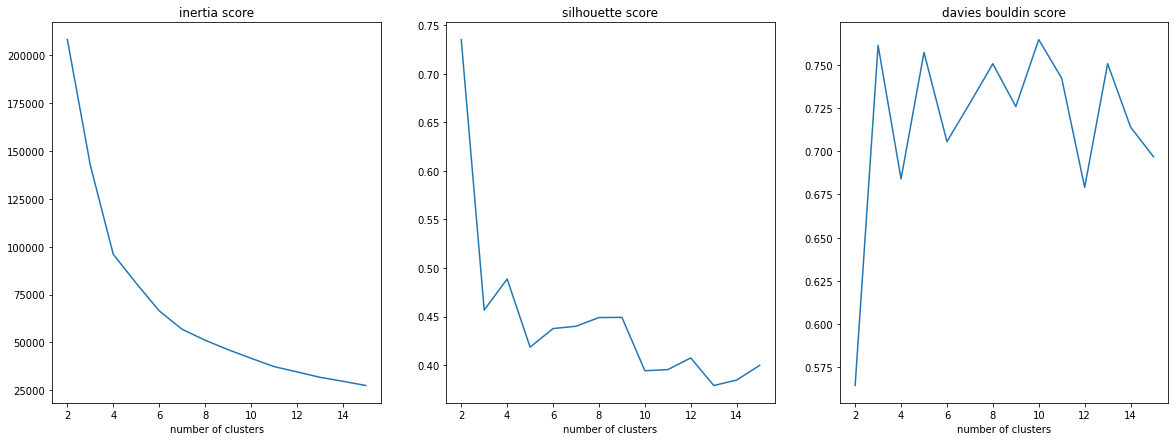

In [41]:
# Test of our clustering with different values of k

simplified_KMeans = test_KMeans(range(2,16), processed_X_simplified)

4 clusters seems a good candidate : elbow of the inertia score, relatively high silhouette score and relatively low davies bouldin score. 2 clusters has a high silhouette score but won't be so interesting to separate our customers for business considerations

## II - Visualisation and interpretation of clusters <a class="anchor" id="11-bullet"></a>

In [34]:
# Fitting our model with selected number of clusters

selected_model = KMeans(n_clusters=4, random_state=0)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_simplified)
fit_time = timeit.default_timer() - start_time

# Predict time
start_time = timeit.default_timer()
prediction = selected_model.predict(processed_X_simplified)
predict_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))
print("Predict time : {:.2f}s".format(predict_time))

Fit time : 0.52s
Predict time : 0.09s


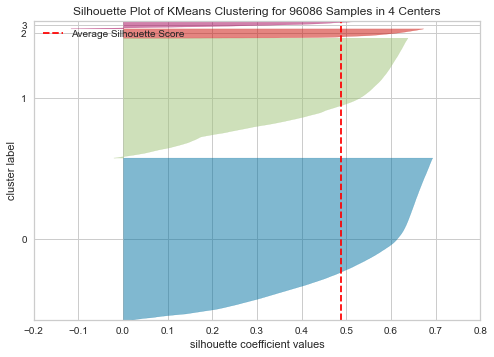

In [38]:
# Looking more detailed silhouette score

plot_silhouette(selected_model, processed_X_simplified)

Total explained variance by 2 components : 70.93%


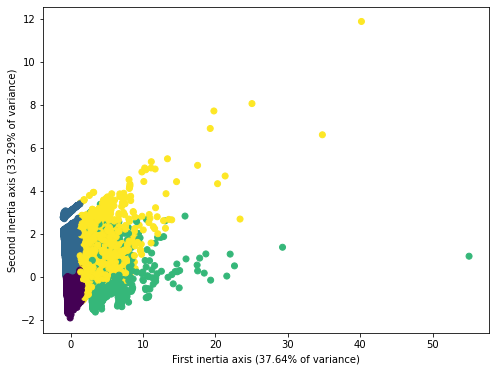

In [35]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_simplified)

70% of explained variance is maybe not enough to have a good visual interpretation on the 2 axis

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


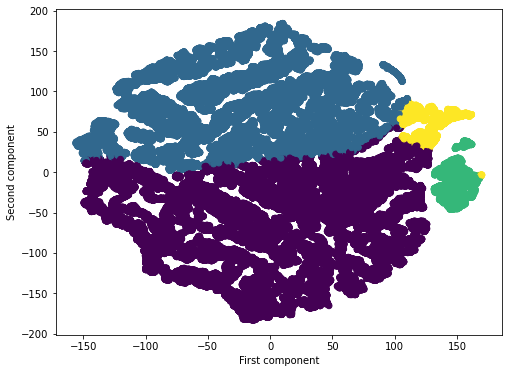

In [94]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_simplified, perplexity=40)

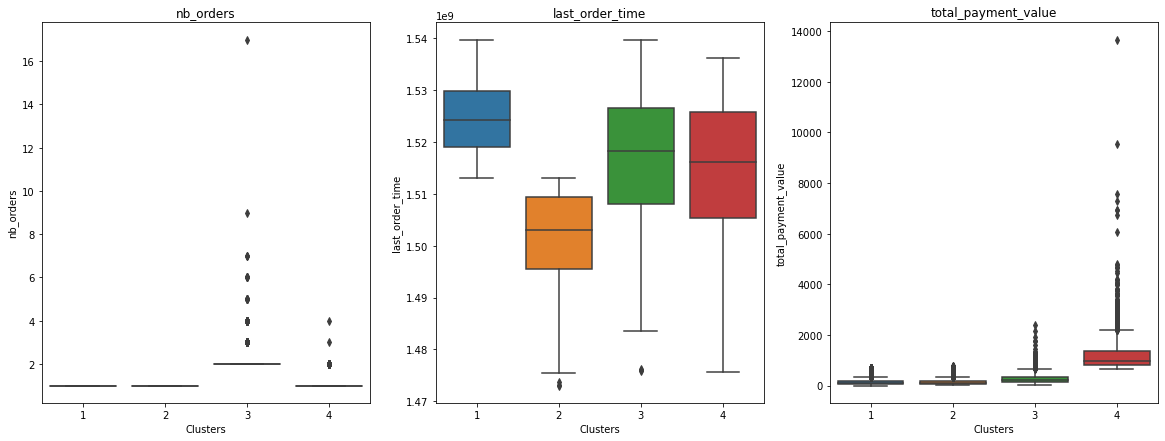

In [116]:
# Visualisation of relation between clusters and variables

relation_variable_clusters(selected_model, X_simplified)

In [44]:
# Getting back the dates variables in initial datetime format
X_simplified['last_order_time'] = X_simplified['last_order_time'].apply(lambda p: datetime.fromtimestamp(p, tz=timezone.utc))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_simplified)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers': '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value
Cluster 1,"52,154",54.28%,1.00,1,1,2018-04-22,2018-10-17,2017-12-13,135.18,703.06,0.00
Cluster 2,"38,549",40.12%,1.00,1,1,2017-08-05,2017-12-13,2016-09-04,134.91,784.80,10.07
Cluster 3,"2,962",3.08%,2.12,17,2,2018-01-21,2018-10-16,2016-10-07,290.31,"2,400.48",34.97
Cluster 4,"2,421",2.52%,1.02,4,1,2018-01-01,2018-09-06,2016-10-04,"1,196.45","13,664.08",654.41


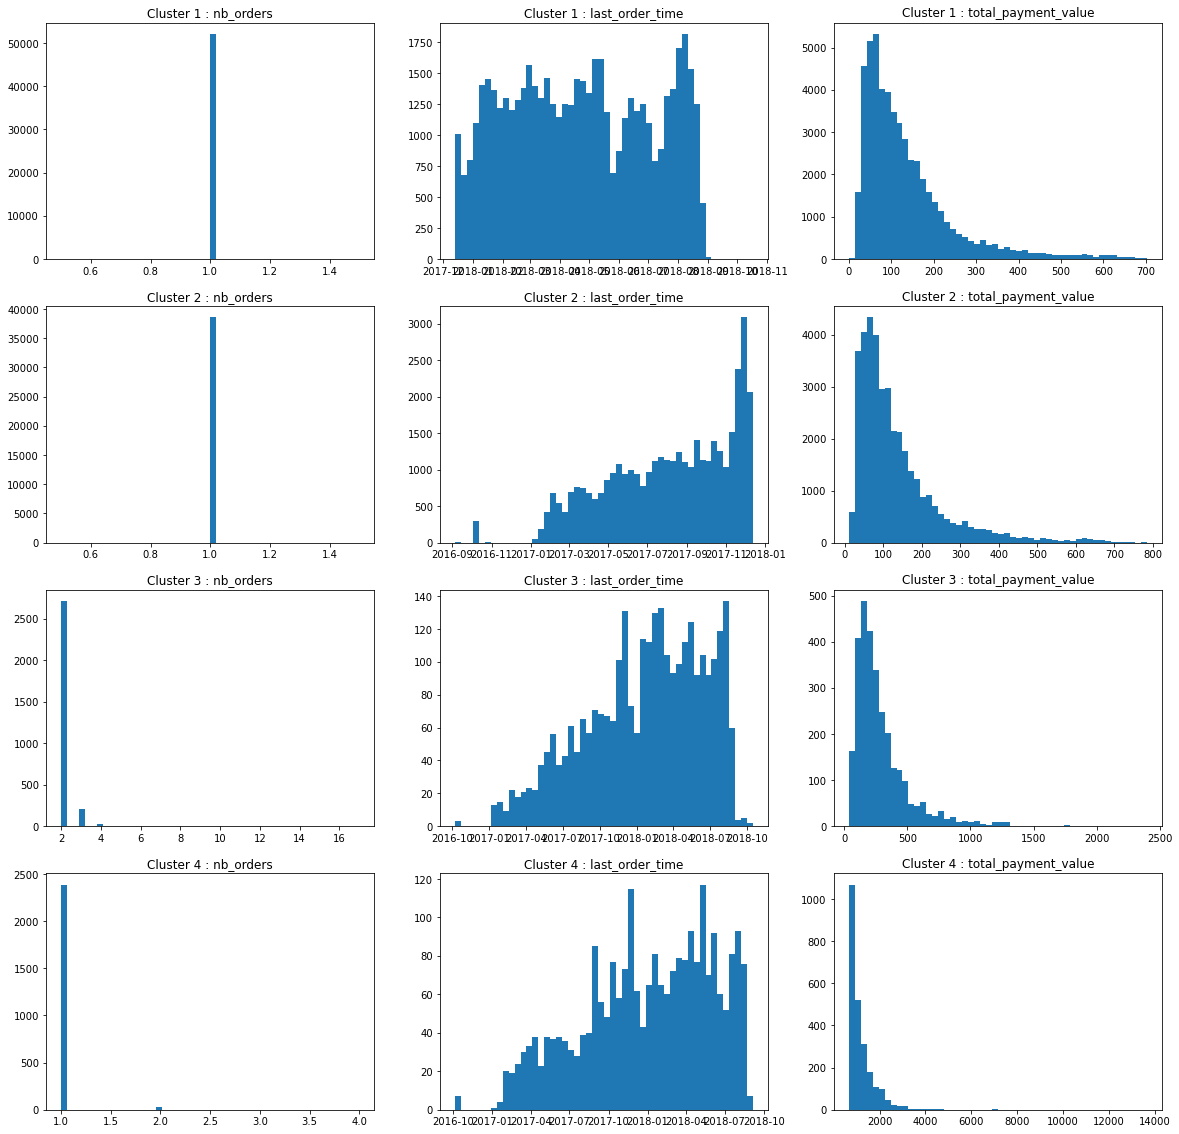

In [53]:
# Visualisation of distribution of variables for each cluster

plot_variables_distributions_clusters(selected_model, X_simplified)

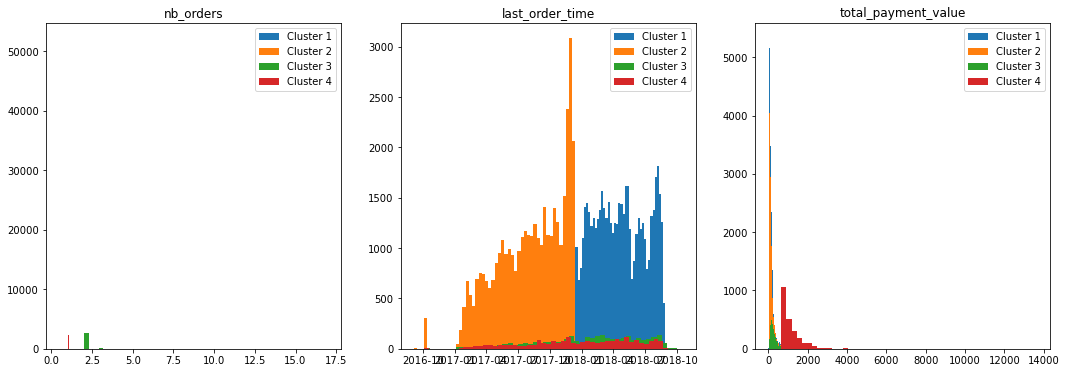

In [55]:
# Visualisation of distribution of variables per clusters on the same chart

plot_variables_aggregated_distributions_clusters(selected_model, X_simplified)

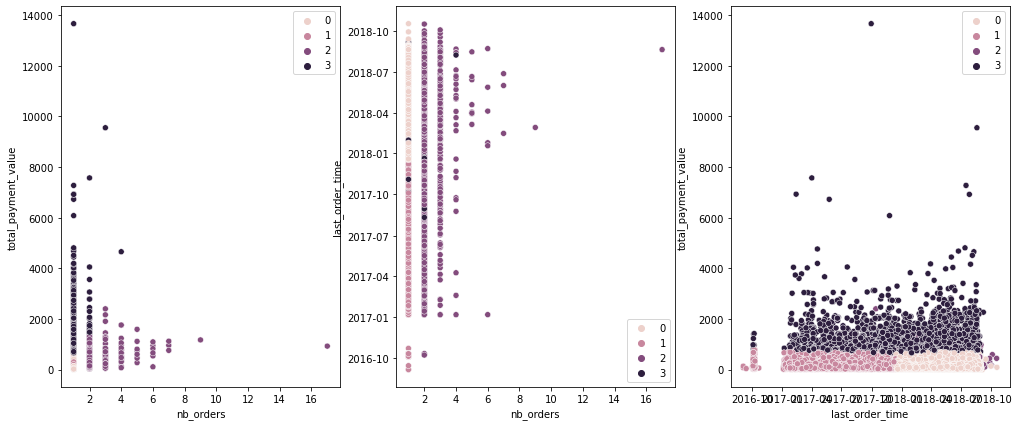

In [68]:
# Bivariate analysis

plt.figure(figsize=(17,7))

plt.subplot(1,3,1)
sns.scatterplot(x='nb_orders', y='total_payment_value', data=X_simplified, hue=selected_model.labels_)

plt.subplot(1,3,2)
sns.scatterplot(x='nb_orders', y='last_order_time', data=X_simplified, hue=selected_model.labels_)

plt.subplot(1,3,3)
sns.scatterplot(x='last_order_time', y='total_payment_value', data=X_simplified, hue=selected_model.labels_)

plt.show()

Interpretation :
- Cluster 1 : Recently active customers / only one order / low amount spent
- Cluster 2 : Not recently active customers / only one order / low amount spent
- Cluster 3 : Quite recently active customer / several orders / medium amount spent
- Cluster 4 : Quite recently active customer / mostly one order / large amount spent

## III - Adding mean_review_score variable <a class="anchor" id="12-bullet"></a>

In [39]:
# Adding review score

X_simplified = X[['nb_orders', 'last_order_time', 'total_payment_value', 'mean_review_score']]
print(X_simplified.shape)
X_simplified.head()

(96086, 4)


,nb_orders,last_order_time,total_payment_value,mean_review_score
0,1,1.494940e+09,146.87,4.0
1,1,1.515787e+09,335.48,5.0
2,1,1.526739e+09,157.73,5.0
3,1,1.520954e+09,173.30,5.0
4,1,1.532851e+09,252.25,5.0


In [40]:
# Preprocessing

processed_X_simplified = simple_preprocessor.fit_transform(X_simplified)

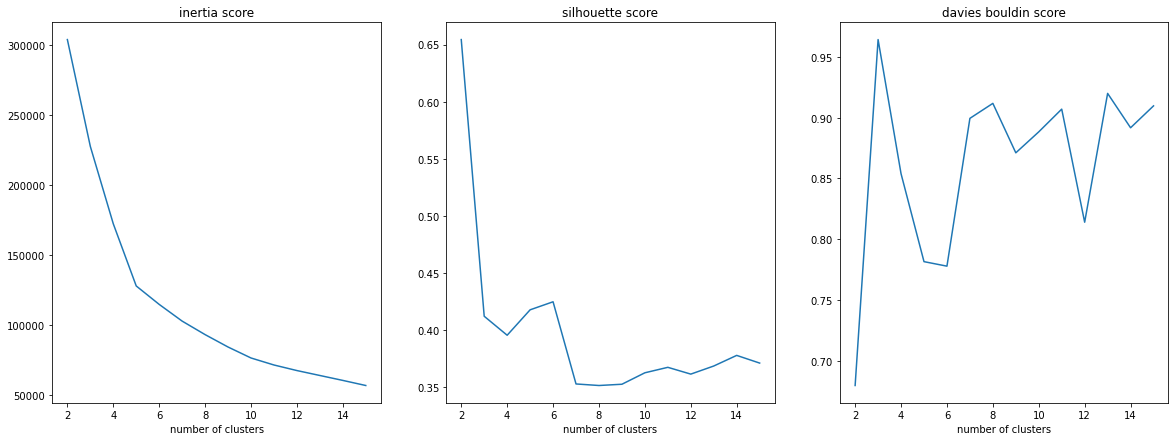

In [70]:
# Test of our clustering with different values of k (preprocessor with only numeric variables is still valid)

simplified_KMeans_2 = test_KMeans(range(2,16), processed_X_simplified)

5 and 6 clusters seems good candidates

### a. 5 clusters

In [41]:
# Fitting our model with selected number of clusters

selected_model = KMeans(n_clusters=5, random_state=0)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_simplified)
fit_time = timeit.default_timer() - start_time

# Predict time
start_time = timeit.default_timer()
prediction = selected_model.predict(processed_X_simplified)
predict_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))
print("Predict time : {:.2f}s".format(predict_time))

Fit time : 0.73s
Predict time : 0.04s


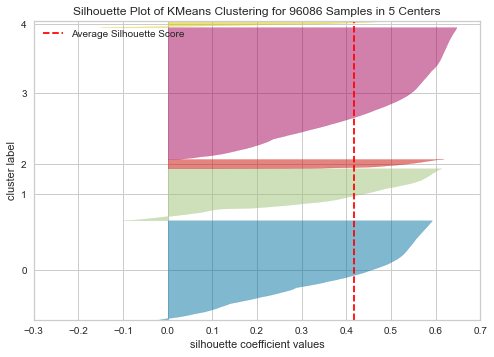

In [42]:
# Looking more detailed silhouette score

plot_silhouette(selected_model, processed_X_simplified)

Total explained variance by 2 components : 54.21%


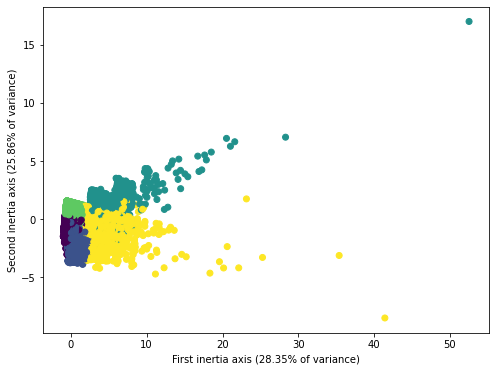

In [101]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_simplified)

54% of explained variance is maybe not enough to have a good visual interpretation on the 2 axis

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


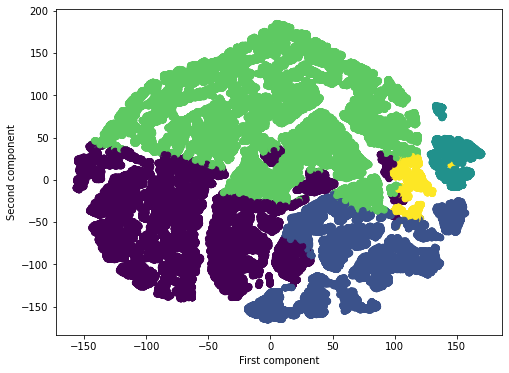

In [102]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_simplified, perplexity=40)

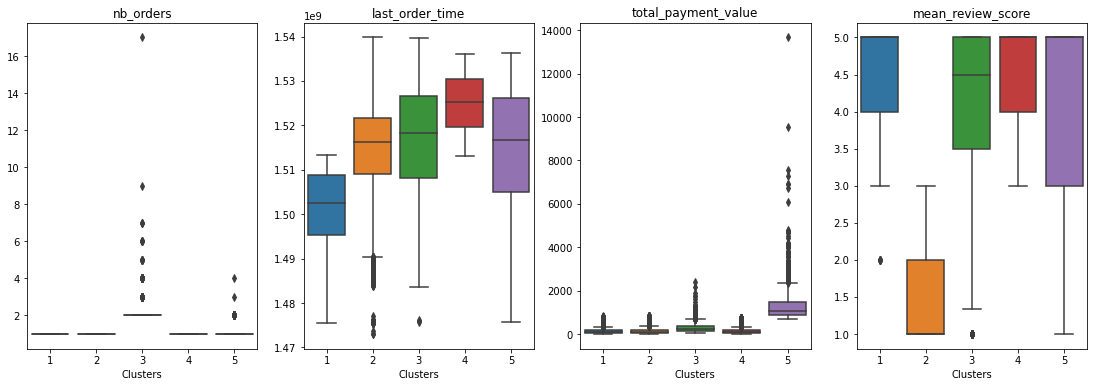

In [127]:
# Visualisation of relation between clusters and variables

relation_variable_clusters(selected_model, X_simplified, figsize=(19,6))

In [76]:
# Getting back the dates variables in initial datetime format
X_simplified['last_order_time'] = X_simplified['last_order_time'].apply(lambda p: datetime.fromtimestamp(p, tz=timezone.utc))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_simplified)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers': '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score
Cluster 1,"31,993",33.30%,1.00,1,1,2017-08-01,2017-12-15,2016-10-03,134.94,818.12,10.07,4.63,5,2
Cluster 2,"16,714",17.39%,1.00,1,1,2017-12-29,2018-10-17,2016-09-04,152.65,829.17,0.00,1.59,3,1
Cluster 3,"2,962",3.08%,2.12,17,2,2018-01-21,2018-10-16,2016-10-07,290.31,"2,400.48",34.97,4.12,5,1
Cluster 4,"42,398",44.13%,1.00,1,1,2018-04-29,2018-09-03,2017-12-13,133.75,758.32,0.00,4.67,5,3
Cluster 5,"2,019",2.10%,1.02,4,1,2018-01-03,2018-09-06,2016-10-04,"1,291.93","13,664.08",696.58,3.96,5,1


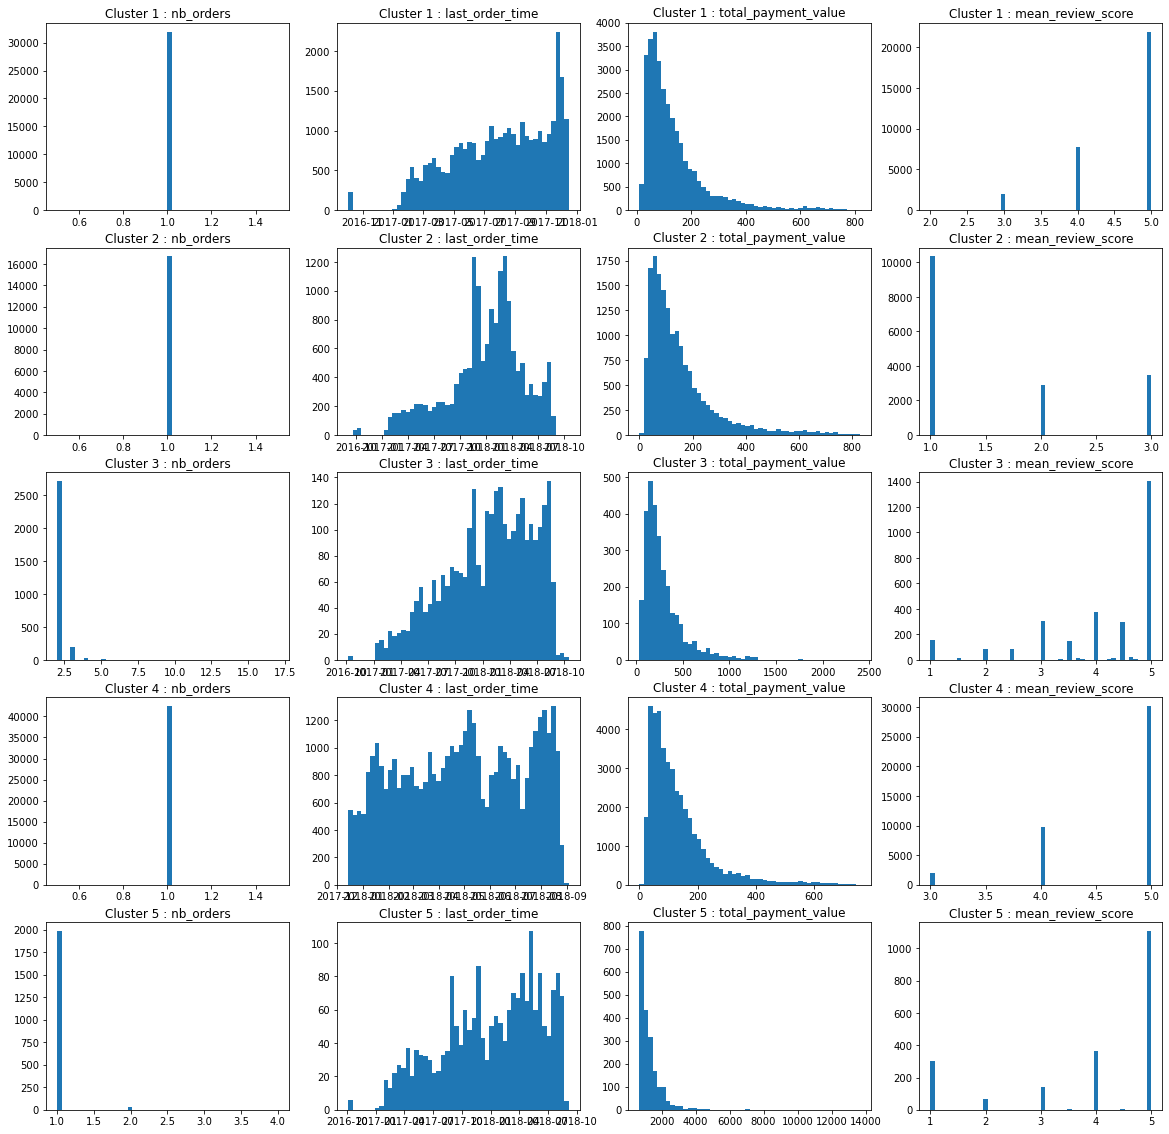

In [78]:
# Visualisation of distribution of variables for each cluster

plot_variables_distributions_clusters(selected_model, X_simplified)

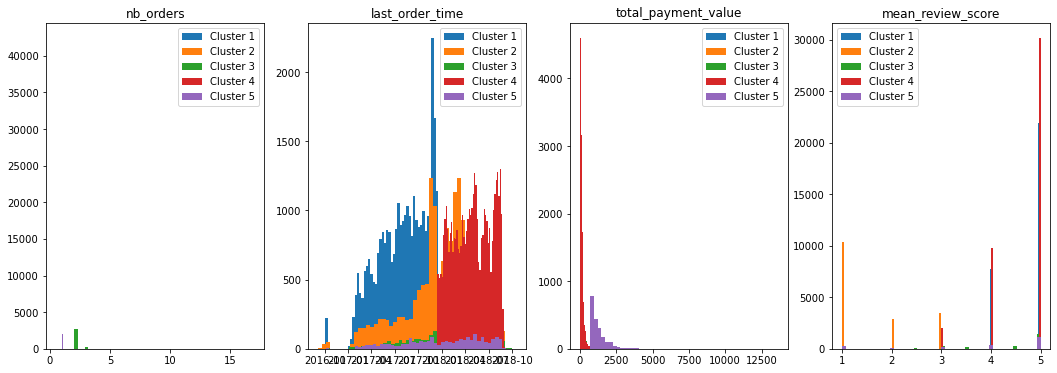

In [79]:
# Visualisation of distribution of variables per clusters on the same chart

plot_variables_aggregated_distributions_clusters(selected_model, X_simplified)

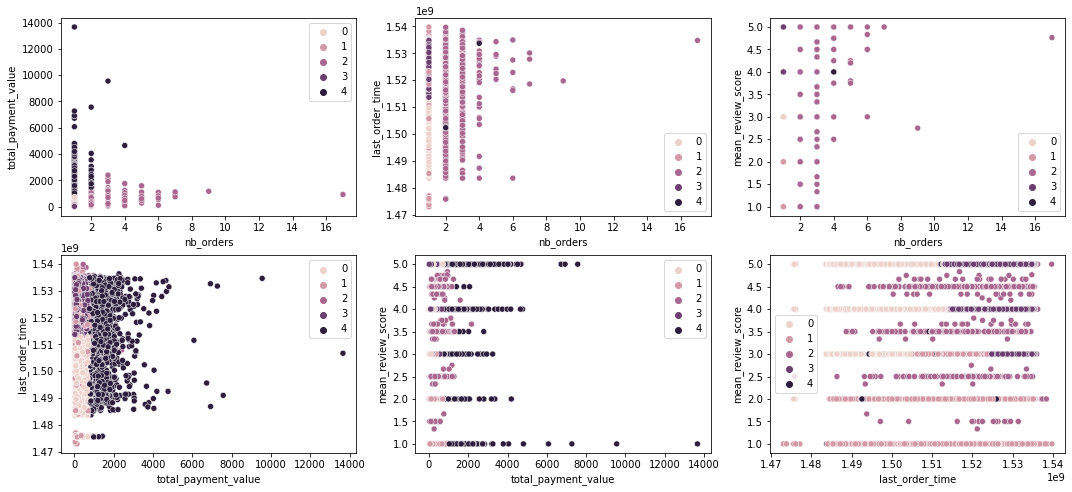

In [128]:
# Bivariate analysis

plt.figure(figsize=(18,8))

plt.subplot(2,3,1)
sns.scatterplot(x='nb_orders', y='total_payment_value', data=X_simplified, hue=selected_model.labels_)

plt.subplot(2,3,2)
sns.scatterplot(x='nb_orders', y='last_order_time', data=X_simplified, hue=selected_model.labels_)

plt.subplot(2,3,3)
sns.scatterplot(x='nb_orders', y='mean_review_score', data=X_simplified, hue=selected_model.labels_)

plt.subplot(2,3,4)
sns.scatterplot(x='total_payment_value', y='last_order_time', data=X_simplified, hue=selected_model.labels_)

plt.subplot(2,3,5)
sns.scatterplot(x='total_payment_value', y='mean_review_score', data=X_simplified, hue=selected_model.labels_)

plt.subplot(2,3,6)
sns.scatterplot(x='last_order_time', y='mean_review_score', data=X_simplified, hue=selected_model.labels_)

plt.show()

Interpretation :
- Cluster 1 : Not recently active customers / only one order / low amount spent / high satisfaction
- Cluster 2 : Not recently active customers / only one order / low amount spent / low satisfaction
- Cluster 3 : Quite recently active customers / several orders / medium amount spent / high satisfaction
- Cluster 4 : Recently active customers / only one order / low amount spent / high satisfaction
- Cluster 5 : Quite recently active customers / mostly one order / high amount spent / medium satisfaction

### b. 6 clusters

In [43]:
# Fitting our model with selected number of clusters

selected_model = KMeans(n_clusters=6, random_state=0)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_simplified)
fit_time = timeit.default_timer() - start_time

# Predict time
start_time = timeit.default_timer()
prediction = selected_model.predict(processed_X_simplified)
predict_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))
print("Predict time : {:.2f}s".format(predict_time))

Fit time : 0.68s
Predict time : 0.04s


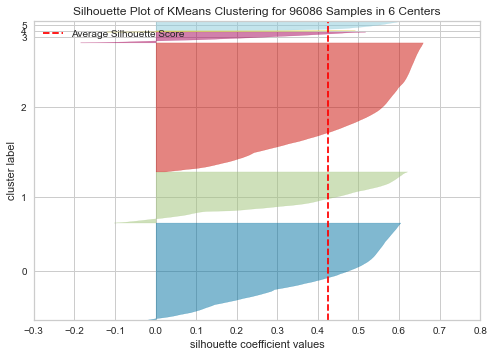

In [44]:
# Looking more detailed silhouette score

plot_silhouette(selected_model, processed_X_simplified)

Total explained variance by 2 components : 54.21%


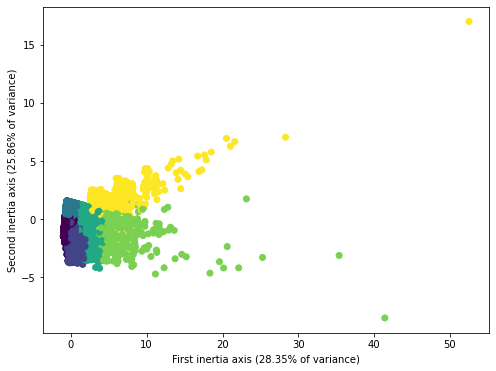

In [104]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_simplified)

54% of explained variance is maybe not enough to have a good visual interpretation on the 2 axis

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


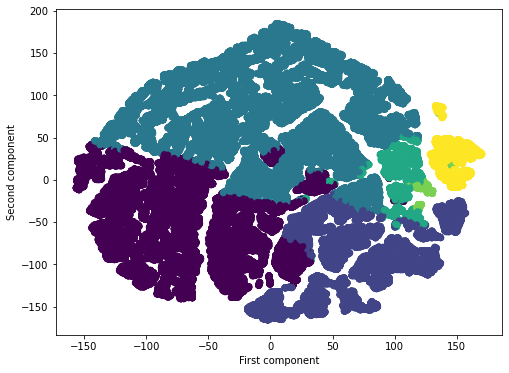

In [105]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_simplified, perplexity=40)

In [85]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_simplified)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers': '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score
Cluster 1,"31,271",32.54%,1.00,1,1,2017-07-31,2017-12-15,2016-10-03,124.30,661.75,10.07,4.63,5,2
Cluster 2,"16,420",17.09%,1.00,1,1,2017-12-29,2018-10-17,2016-09-04,144.25,691.49,0.00,1.58,3,1
Cluster 3,"41,486",43.18%,1.00,1,1,2018-04-29,2018-09-03,2017-12-13,123.47,530.16,0.00,4.67,5,3
Cluster 4,"3,474",3.62%,1.00,1,1,2018-01-04,2018-08-28,2016-10-04,784.06,"1,517.70",415.78,4.18,5,1
Cluster 5,466,0.48%,1.07,4,1,2018-01-02,2018-09-06,2017-01-26,"2,225.60","13,664.08","1,478.95",3.62,5,1
Cluster 6,"2,969",3.09%,2.12,17,2,2018-01-21,2018-10-16,2016-10-07,292.48,"1,906.68",34.97,4.12,5,1


One cluster has very few customers, so using k=6 doesn't seem relevant

## IV - Adding customer_state variable <a class="anchor" id="13-bullet"></a>

In [45]:
# Adding customer_state

X_simplified = X[['nb_orders', 'last_order_time', 'total_payment_value', 'mean_review_score', 'customer_state']]
print(X_simplified.shape)
X_simplified.head()

(96086, 5)


,nb_orders,last_order_time,total_payment_value,mean_review_score,customer_state
0,1,1.494940e+09,146.87,4.0,SP
1,1,1.515787e+09,335.48,5.0,SP
2,1,1.526739e+09,157.73,5.0,SP
3,1,1.520954e+09,173.30,5.0,SP
4,1,1.532851e+09,252.25,5.0,SP


In [46]:
# Definition of preprocessing steps

# Defining numerical and categorical columns
categorical_cols = ['customer_state']
numerical_cols = list(X_simplified.drop(categorical_cols, axis=1).columns)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

processed_X_simplified = preprocessor.fit_transform(X_simplified)

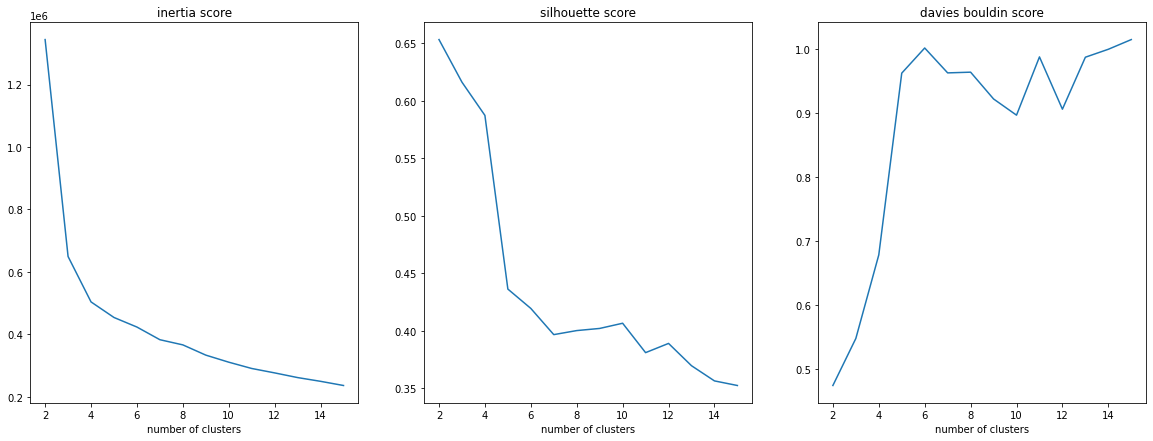

In [103]:
# Test of our clustering with different values of k

simplified_KMeans_3 = test_KMeans(range(2,16), processed_X_simplified)

4 clusters seems a good candidate

In [47]:
# Fitting our model with selected number of clusters

selected_model = KMeans(n_clusters=4, random_state=0)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_simplified)
fit_time = timeit.default_timer() - start_time

# Predict time
start_time = timeit.default_timer()
prediction = selected_model.predict(processed_X_simplified)
predict_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))
print("Predict time : {:.2f}s".format(predict_time))

Fit time : 0.27s
Predict time : 0.04s


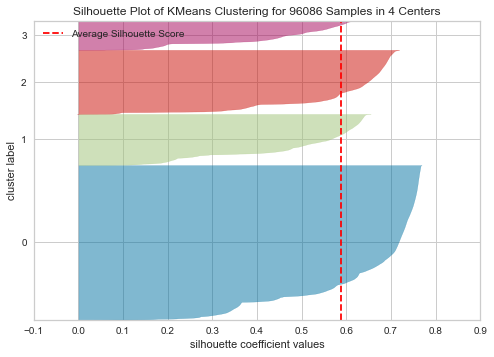

In [48]:
# Looking more detailed silhouette score

plot_silhouette(selected_model, processed_X_simplified)

Total explained variance by 2 components : 94.72%


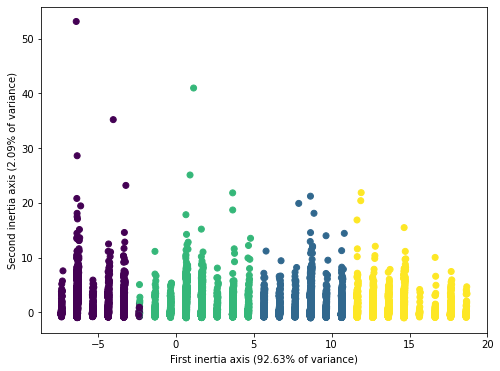

In [39]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_simplified)

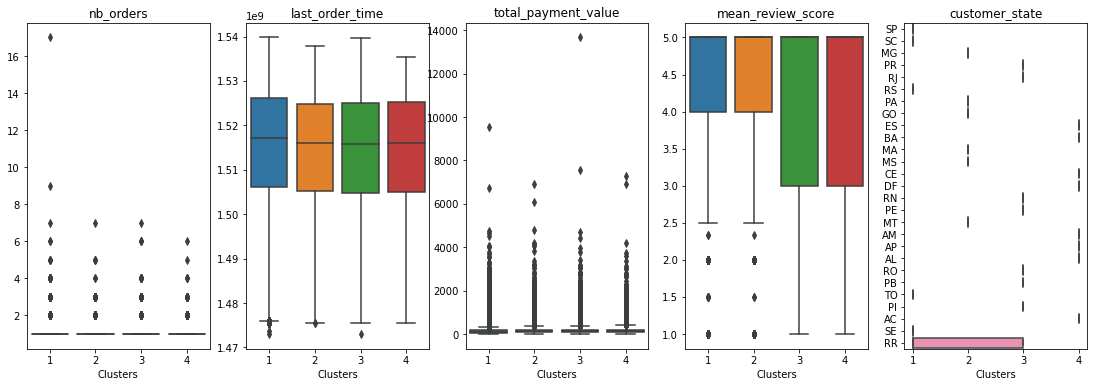

In [59]:
# Visualisation of relation between clusters and variables

relation_variable_clusters(selected_model, X_simplified, figsize=(19,6))

In [46]:
# Getting back the dates variables in initial datetime format
X_simplified['last_order_time'] = X_simplified['last_order_time'].apply(lambda p: datetime.fromtimestamp(p, tz=timezone.utc))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_simplified)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers' : '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
    'mode_%_customer_state' : '{:.2%}'
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score,mode_customer_state,mode_%_customer_state
Cluster 1,"49,733",51.76%,1.04,17,1,2018-01-08,2018-10-17,2016-09-04,153.90,"9,553.02",0.00,4.16,5,1,SP,81.00%
Cluster 2,"16,448",17.12%,1.03,7,1,2017-12-26,2018-09-25,2016-10-03,177.43,"6,929.31",12.89,4.09,5,1,MG,68.43%
Cluster 3,"20,594",21.43%,1.04,7,1,2017-12-25,2018-10-16,2016-09-04,179.56,"13,664.08",12.89,3.97,5,1,RJ,60.10%
Cluster 4,"9,311",9.69%,1.03,6,1,2017-12-29,2018-08-28,2016-10-04,186.57,"7,274.88",20.60,3.95,5,1,BA,35.18%


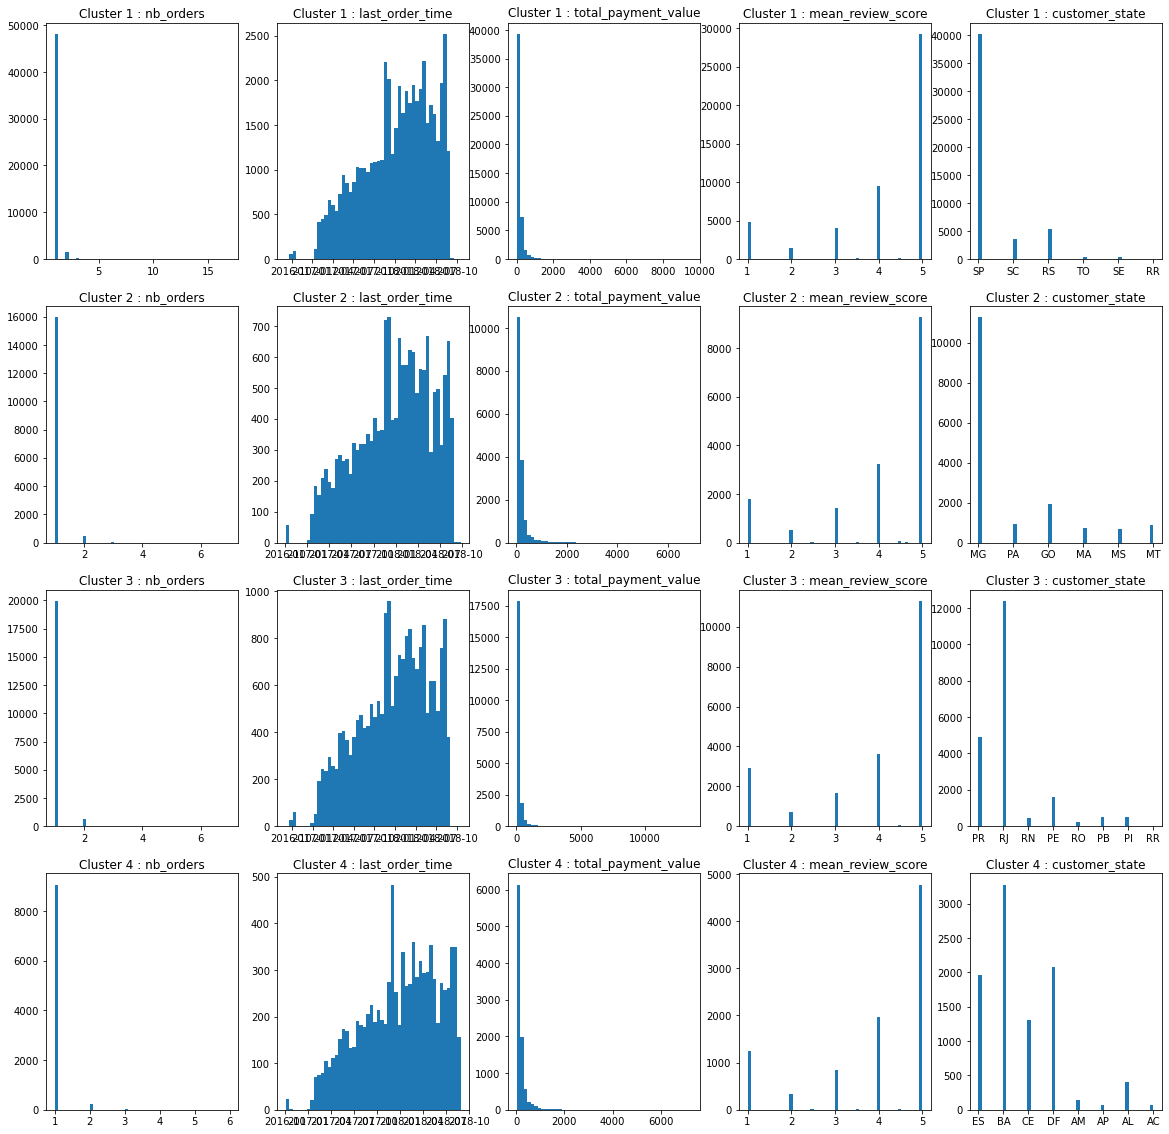

In [42]:
# Visualisation of distribution of variables for each cluster

plot_variables_distributions_clusters(selected_model, X_simplified)

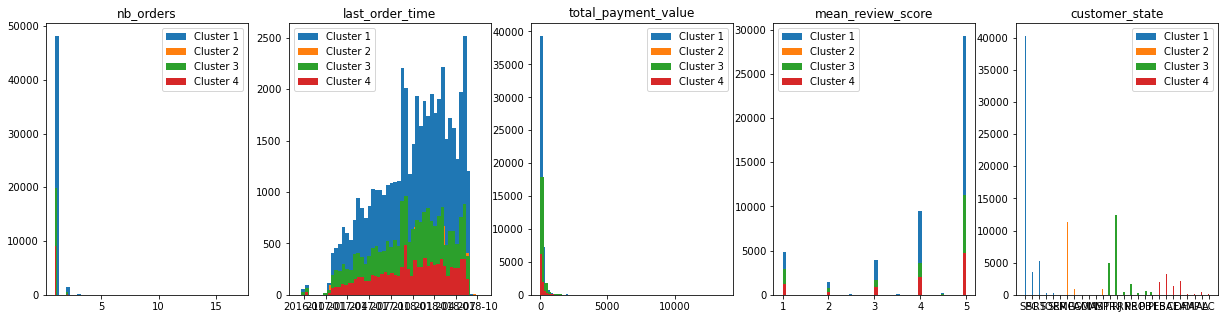

In [43]:
# Visualisation of distribution of variables per clusters on the same chart

plot_variables_aggregated_distributions_clusters(selected_model, X_simplified, figsize=(21,5))

Introducing customer_state variable doesn't allow us to create clusters with a good differentiation on other variables. The only important difference between clusters is on customer_state, which is probably not the most important information for business considerations

# 4. DBSCAN <a class="anchor" id="14-bullet"></a>

In [49]:
from sklearn.cluster import DBSCAN

In [50]:
# We keep the variables which seems to make more sense for business considerations

X_simplified = X[['nb_orders', 'last_order_time', 'total_payment_value', 'mean_review_score']]
print(X_simplified.shape)
X_simplified.head()

(96086, 4)


,nb_orders,last_order_time,total_payment_value,mean_review_score
0,1,1.494940e+09,146.87,4.0
1,1,1.515787e+09,335.48,5.0
2,1,1.526739e+09,157.73,5.0
3,1,1.520954e+09,173.30,5.0
4,1,1.532851e+09,252.25,5.0


In [51]:
# Only numerical values, we creates a simplified preprocessing

simple_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())])

processed_X_simplified = simple_preprocessor.fit_transform(X_simplified)

My computer doesn't seem able to run multiple tests on DBSCAN (with a loop on parameters) so i do it one at a time

Even one at a time it's still not able to run with the whole dataset, I unfortunatelly have to reduce it

In [52]:
from sklearn.model_selection import train_test_split

processed_X_reduced_1, processed_X_reduced_2, X_reduced_1, X_reduced_2 = train_test_split(processed_X_simplified, X_simplified, test_size=0.5, random_state=0)

## I - Binary search for eps <a class="anchor" id="20-bullet"></a>

In [42]:
# EPS = 50 / min_samples = 50

model = DBSCAN(eps=50, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 1


In [43]:
# EPS = 25 / min_samples = 50

model = DBSCAN(eps=25, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 1


In [44]:
# EPS = 12 / min_samples = 50

model = DBSCAN(eps=12, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 1


In [46]:
# EPS = 6 / min_samples = 50

model = DBSCAN(eps=6, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 1


In [47]:
# EPS = 3 / min_samples = 50

model = DBSCAN(eps=3, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 3


In [48]:
# EPS = 1.5 / min_samples = 50

model = DBSCAN(eps=1.5, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 3


In [49]:
# EPS = 0.75 / min_samples = 50

model = DBSCAN(eps=0.75, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 2


In [50]:
# EPS = 0.5 / min_samples = 50

model = DBSCAN(eps=0.5, min_samples=50, metric='euclidean', n_jobs=-1) 
model.fit(processed_X_reduced_1)

print("Number of clusters : {:.0f}".format(max(model.labels_) + 1))

Number of clusters : 7


## II - Selecting best parameters <a class="anchor" id="21-bullet"></a>

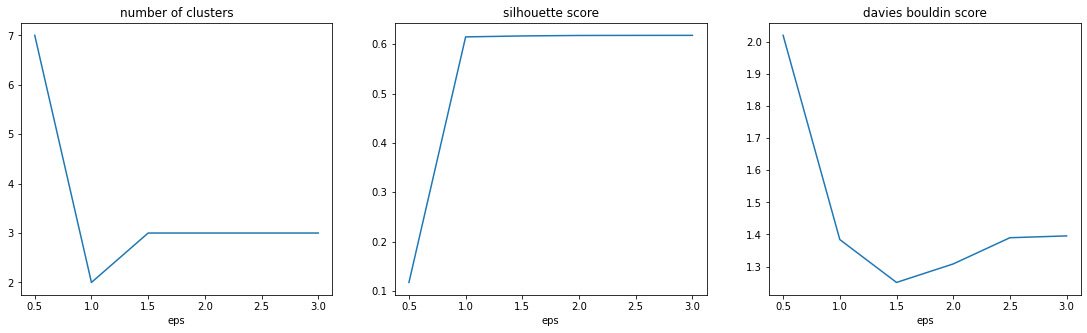

In [54]:
# DBSCAN with min_samples=50

DBSCAN_50 = test_DBSCAN(processed_X_reduced_1, eps_range=np.linspace(0.5,3,6), min_samples=50)

In [56]:
DBSCAN_50

,eps,nb_clusters,silhouette_scores,davies_bouldin_scores
0,0.5,7,0.117331,2.019606
1,1.0,2,0.614675,1.384000
2,1.5,3,0.616599,1.250617
3,2.0,3,0.617550,1.308230
4,2.5,3,0.617699,1.389802
5,3.0,3,0.617785,1.395476


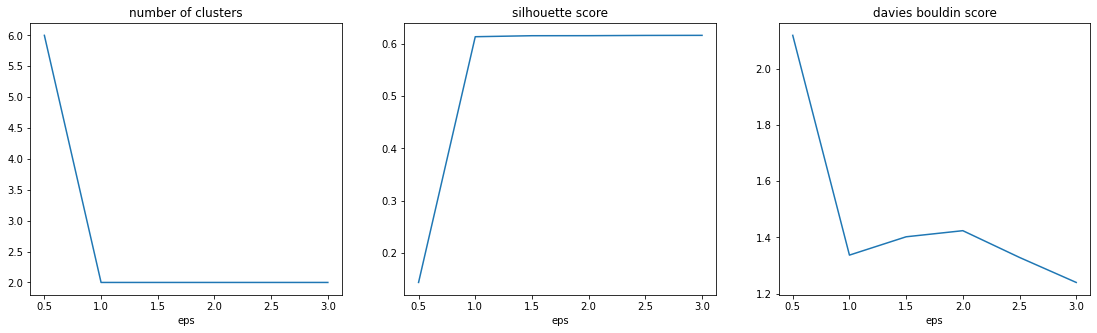

In [57]:
# DBSCAN with min_samples=100

DBSCAN_100 = test_DBSCAN(processed_X_reduced_1, eps_range=np.linspace(0.5,3,6), min_samples=100)

In [58]:
DBSCAN_100

,eps,nb_clusters,silhouette_scores,davies_bouldin_scores
0,0.5,6,0.143520,2.119122
1,1.0,2,0.613875,1.337099
2,1.5,2,0.615785,1.402288
3,2.0,2,0.615864,1.424019
4,2.5,2,0.616336,1.328767
5,3.0,2,0.616479,1.239816


The best combination which maximizes silhouette score and minimizes davies bouldin score is n_samples = 50 and eps = 1.5

## III - Selected model <a class="anchor" id="22-bullet"></a>

In [54]:
selected_model = DBSCAN(eps=1.5, min_samples=50, metric='euclidean', n_jobs=-1) 

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_reduced_1)
fit_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))

Fit time : 17.67s


Total explained variance by 2 components : 54.03%


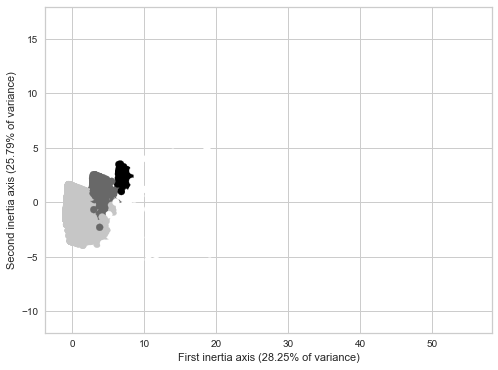

In [57]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_reduced_1)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


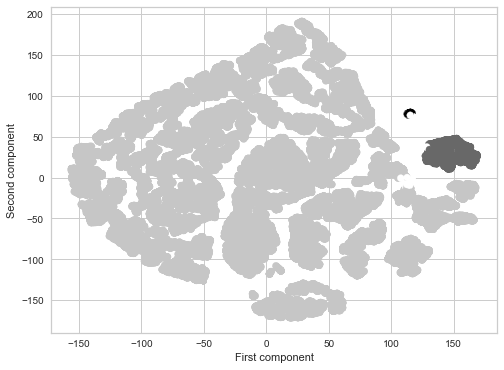

In [58]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_reduced_1, perplexity=40)

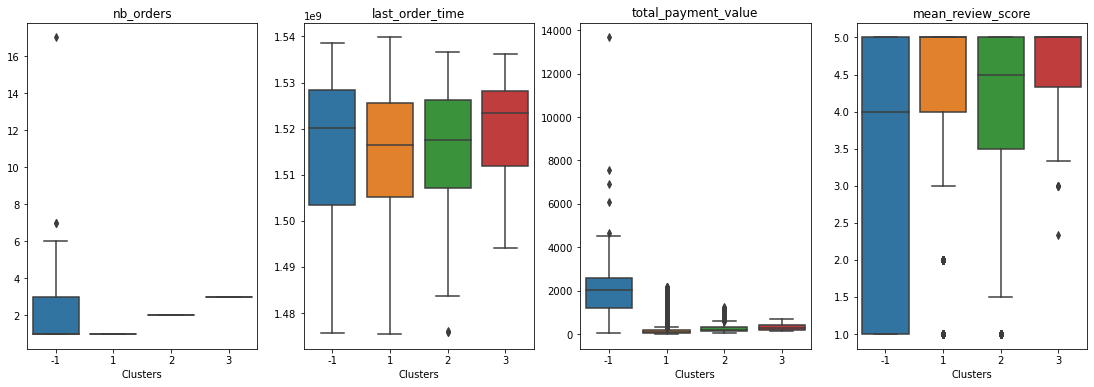

In [79]:
# Visualisation of relation between clusters and variables

nb_clusters = max(selected_model.labels_) + 2
variables = X_reduced_1.columns
nb_var = X_reduced_1.shape[1]

plt.figure(figsize=(19,6))

for i, var in enumerate(variables):
    plt.subplot(1, nb_var, i+1)
    sns.boxplot(x=selected_model.labels_, y=var, data=X_reduced_1)
    plt.title(var)
    plt.xlabel('Clusters')
    plt.ylabel(None)
    plt.xticks(ticks=[i for i in range(0, nb_clusters)], labels=[-1, 1, 2, 3])

In [63]:
# Getting back the dates variables in initial datetime format
X_reduced_1['last_order_time'] = X_reduced_1['last_order_time'].apply(lambda p: datetime.fromtimestamp(p, tz=timezone.utc))

In [64]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_reduced_1)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers' : '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score
Cluster 1,"46,450",96.68%,1.04,17,1,2018-01-01,2018-10-17,2016-10-02,165.23,"7,571.63",9.59,4.09,5,1
Cluster 2,"1,347",2.80%,1.03,4,1,2018-01-03,2018-08-26,2016-10-04,181.57,"13,664.08",15.86,4.10,5,1
Cluster 3,82,0.17%,1.06,2,1,2017-12-22,2018-08-22,2017-01-24,231.13,"2,416.00",23.36,4.09,5,1


We don't have enough customers in one cluster, we could try with n_samples = 100 but we only get 2 clusters which is not really interesting for business considerations. DBSCAN doesn't seem really effective to deal with this dataset

# 5. Agglomerative clustering <a class="anchor" id="15-bullet"></a>

## I - Clusters selection <a class="anchor" id="16-bullet"></a>

In [59]:
from sklearn.cluster import AgglomerativeClustering

In [60]:
# We keep the variables which seems to make more sense for business considerations

X_simplified = X[['nb_orders', 'last_order_time', 'total_payment_value', 'mean_review_score']]
print(X_simplified.shape)
X_simplified.head()

(96086, 4)


,nb_orders,last_order_time,total_payment_value,mean_review_score
0,1,1.494940e+09,146.87,4.0
1,1,1.515787e+09,335.48,5.0
2,1,1.526739e+09,157.73,5.0
3,1,1.520954e+09,173.30,5.0
4,1,1.532851e+09,252.25,5.0


In [61]:
# Only numerical values, we creates a simplified preprocessing

simple_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())])

processed_X_simplified = simple_preprocessor.fit_transform(X_simplified)

In [62]:
# As for DBSCAN, we reduce the dataset. 
# With the whole dataset, python specifies that 34 GB of memory are necessary to run the clustering with this dataset, which I don't have

from sklearn.model_selection import train_test_split

processed_X_reduced_1, processed_X_reduced_2, X_reduced_1, X_reduced_2 = train_test_split(processed_X_simplified, X_simplified, test_size=0.5, random_state=0)

In [35]:
# Running agglomerative clustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(processed_X_reduced_1)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

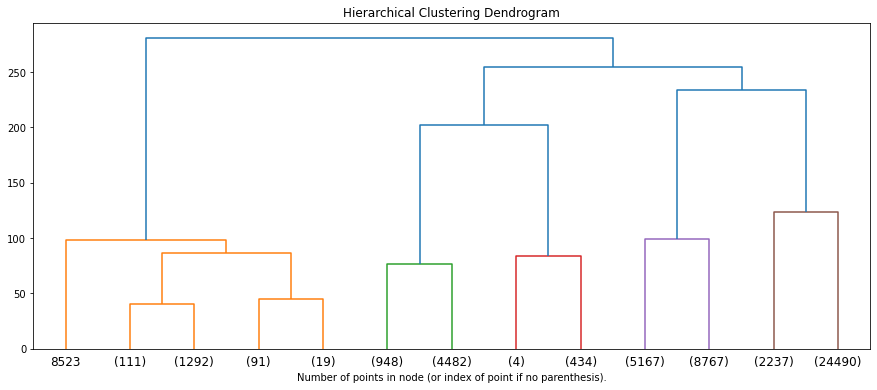

In [36]:
plt.figure(figsize=(15,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The optimal number of clusters seems to be 5, we can also try 4 clusters because we seem to have one cluster with few customers here

## II - 5 clusters <a class="anchor" id="17-bullet"></a>

In [64]:
selected_model = AgglomerativeClustering(n_clusters=5)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_reduced_1)
fit_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))

Fit time : 432.72s


In [65]:
# Displaying scores

print("silhouette score : {:.2f}".format(metrics.silhouette_score(processed_X_reduced_1, selected_model.labels_)))
print("davies bouldin score : {:.2f}".format(metrics.davies_bouldin_score(processed_X_reduced_1, selected_model.labels_)))

silhouette score : 0.38
davies bouldin score : 0.80


Total explained variance by 2 components : 54.03%


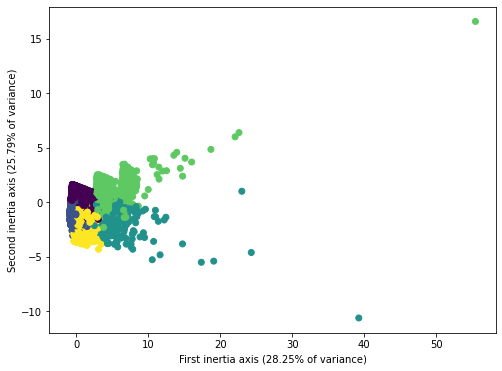

In [110]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_reduced_1)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


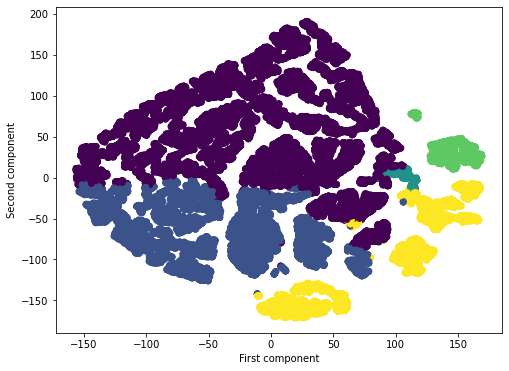

In [113]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_reduced_1, perplexity=40)

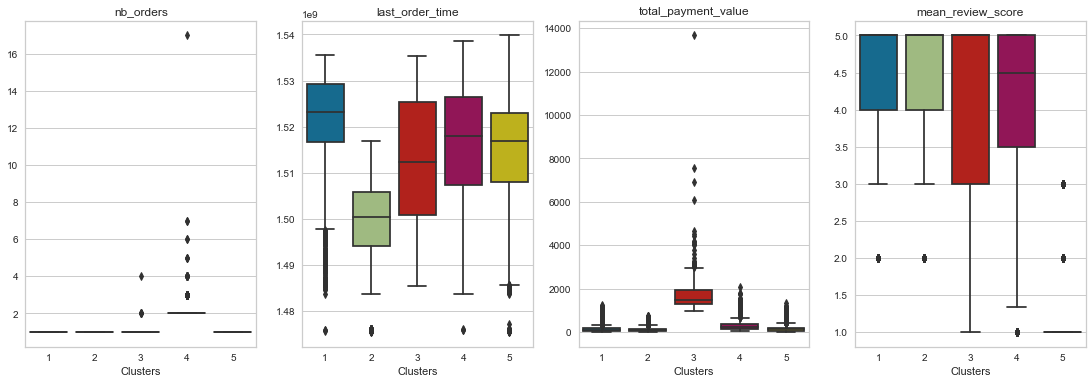

In [67]:
# Visualisation of relation between clusters and variables

relation_variable_clusters(selected_model, X_reduced_1, figsize=(19,6))

In [38]:
# Getting back the dates variables in initial datetime format
X_reduced_1['last_order_time'] = X_reduced_1['last_order_time'].apply(lambda p: datetime.fromtimestamp(p, tz=timezone.utc))

In [42]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_reduced_1)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers' : '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score
Cluster 1,"26,727",55.63%,1.00,1,1,2018-04-02,2018-08-29,2016-10-05,148.40,"1,230.20",9.59,4.58,5,2
Cluster 2,"13,934",29.00%,1.00,1,1,2017-07-12,2018-01-24,2016-10-03,128.14,757.97,10.07,4.33,5,2
Cluster 3,438,0.91%,1.02,4,1,2017-12-05,2018-08-26,2017-01-25,"1,754.59","13,664.08",971.10,3.84,5,1
Cluster 4,"1,514",3.15%,2.10,17,2,2018-01-18,2018-10-03,2016-10-07,296.29,"2,068.68",34.97,4.13,5,1
Cluster 5,"5,430",11.30%,1.00,1,1,2017-12-29,2018-10-17,2016-10-02,183.16,"1,323.30",13.78,1.06,3,1


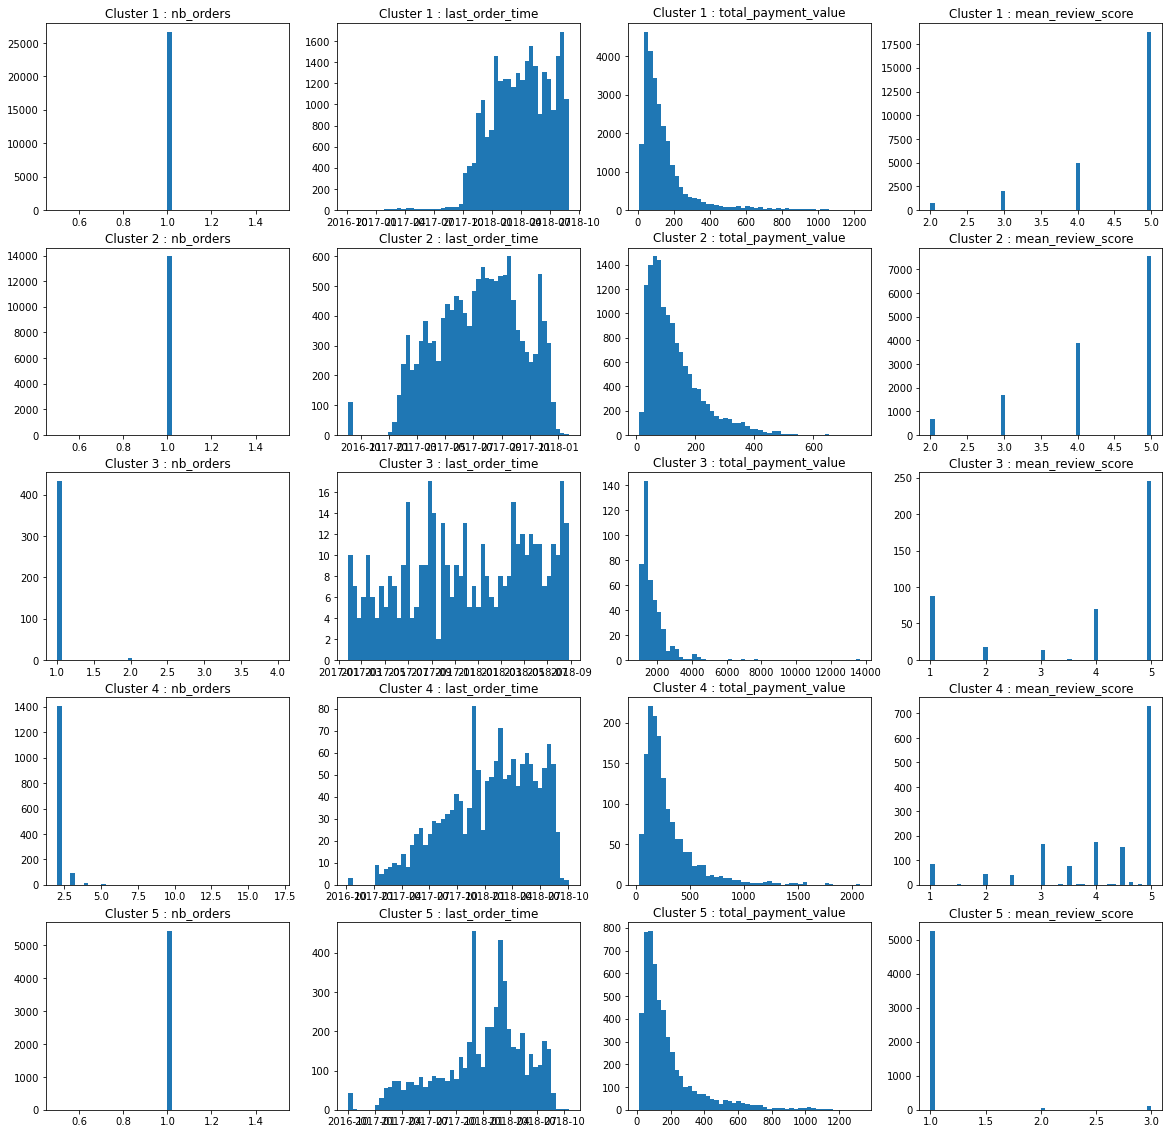

In [43]:
# Visualisation of distribution of variables for each cluster

plot_variables_distributions_clusters(selected_model, X_reduced_1)

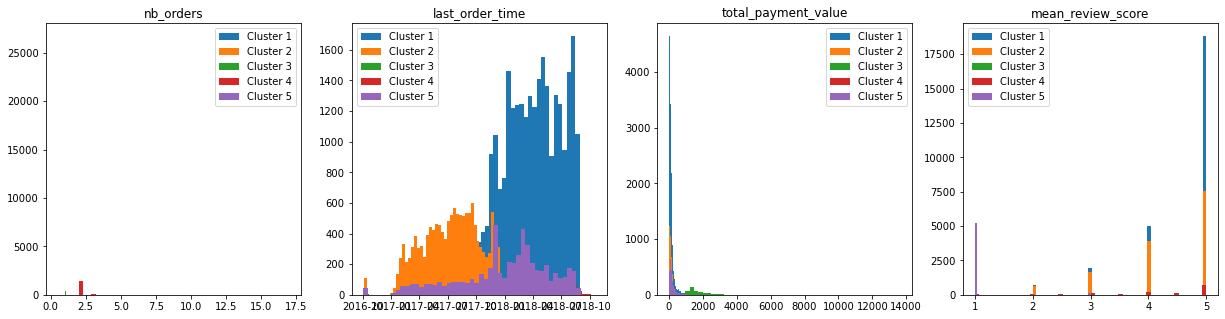

In [44]:
# Visualisation of distribution of variables per clusters on the same chart

plot_variables_aggregated_distributions_clusters(selected_model, X_reduced_1, figsize=(21,5))

Interpretation :
- Cluster 1 : Recently active customers / only one order / low amount spent / high satisfaction
- Cluster 2 : Not recently active customers / only one order / low amount spent / high satisfaction
- Cluster 3 : Quite recently active customers / mostly one order / high amount spent / medium satisfaction
- Cluster 4 : Quite recently active customers / several orders / medium amount spent / high satisfaction
- Cluster 5 : Quite recently active customers / only one order / low amount spent / low satisfaction

## III - 4 clusters <a class="anchor" id="18-bullet"></a>

In [69]:
selected_model = AgglomerativeClustering(n_clusters=4)

# Fitting and computing time
start_time = timeit.default_timer()
selected_model.fit(processed_X_reduced_1)
fit_time = timeit.default_timer() - start_time

print("Fit time : {:.2f}s".format(fit_time))

Fit time : 314.17s


In [70]:
# Displaying scores

print("silhouette score : {:.2f}".format(metrics.silhouette_score(processed_X_reduced_1, selected_model.labels_)))
print("davies bouldin score : {:.2f}".format(metrics.davies_bouldin_score(processed_X_reduced_1, selected_model.labels_)))

silhouette score : 0.37
davies bouldin score : 0.92


Total explained variance by 2 components : 54.03%


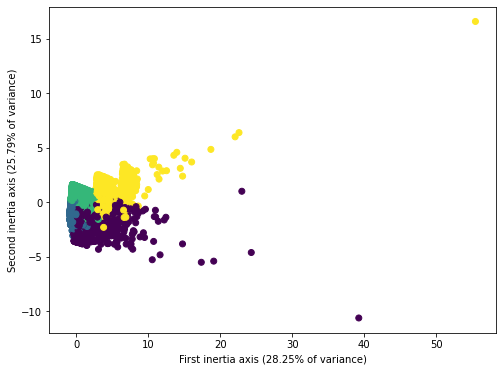

In [115]:
# We use a PCA to display our clustering in the 2 first components

display_clustering_2D(selected_model, processed_X_reduced_1)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


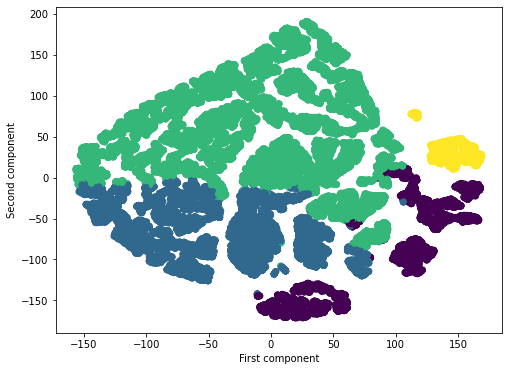

In [116]:
# Same thing with TSNE

display_clustering_2D_TSNE(selected_model, processed_X_reduced_1, perplexity=40)

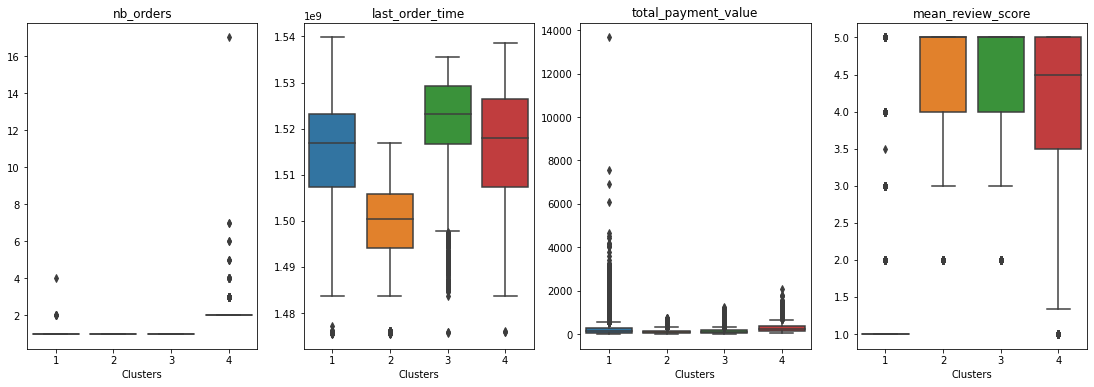

In [83]:
# Visualisation of relation between clusters and variables

relation_variable_clusters(selected_model, X_reduced_1, figsize=(19,6))

In [50]:
# Look at clusters characteristics

df_clusters = display_clusters_characteristics(selected_model, X_reduced_1)

# Formatting df

style_dict = {
    'nb_customers' : '{:,}',
    'prop_customers' : '{:.2%}',
    'mean_nb_orders' : '{:,.2f}',
    'mean_total_payment_value' : '{:,.2f}',
    'max_total_payment_value' : '{:,.2f}',
    'min_total_payment_value' : '{:,.2f}',
    'mean_mean_review_score' : '{:,.2f}',
    'max_mean_review_score' : '{:,.0f}',
    'min_mean_review_score' : '{:,.0f}',
}

for time_var in ['mean_last_order_time', 'max_last_order_time', 'min_last_order_time']:
    df_clusters[time_var] = df_clusters[time_var].apply(lambda p: p.strftime("%Y-%m-%d"))

df_clusters.style.format(style_dict)

,nb_customers,prop_customers,mean_nb_orders,max_nb_orders,min_nb_orders,mean_last_order_time,max_last_order_time,min_last_order_time,mean_total_payment_value,max_total_payment_value,min_total_payment_value,mean_mean_review_score,max_mean_review_score,min_mean_review_score
Cluster 1,"5,868",12.21%,1.00,4,1,2017-12-27,2018-10-17,2016-10-02,300.45,"13,664.08",13.78,1.26,5,1
Cluster 2,"13,934",29.00%,1.00,1,1,2017-07-12,2018-01-24,2016-10-03,128.14,757.97,10.07,4.33,5,2
Cluster 3,"26,727",55.63%,1.00,1,1,2018-04-02,2018-08-29,2016-10-05,148.40,"1,230.20",9.59,4.58,5,2
Cluster 4,"1,514",3.15%,2.10,17,2,2018-01-18,2018-10-03,2016-10-07,296.29,"2,068.68",34.97,4.13,5,1


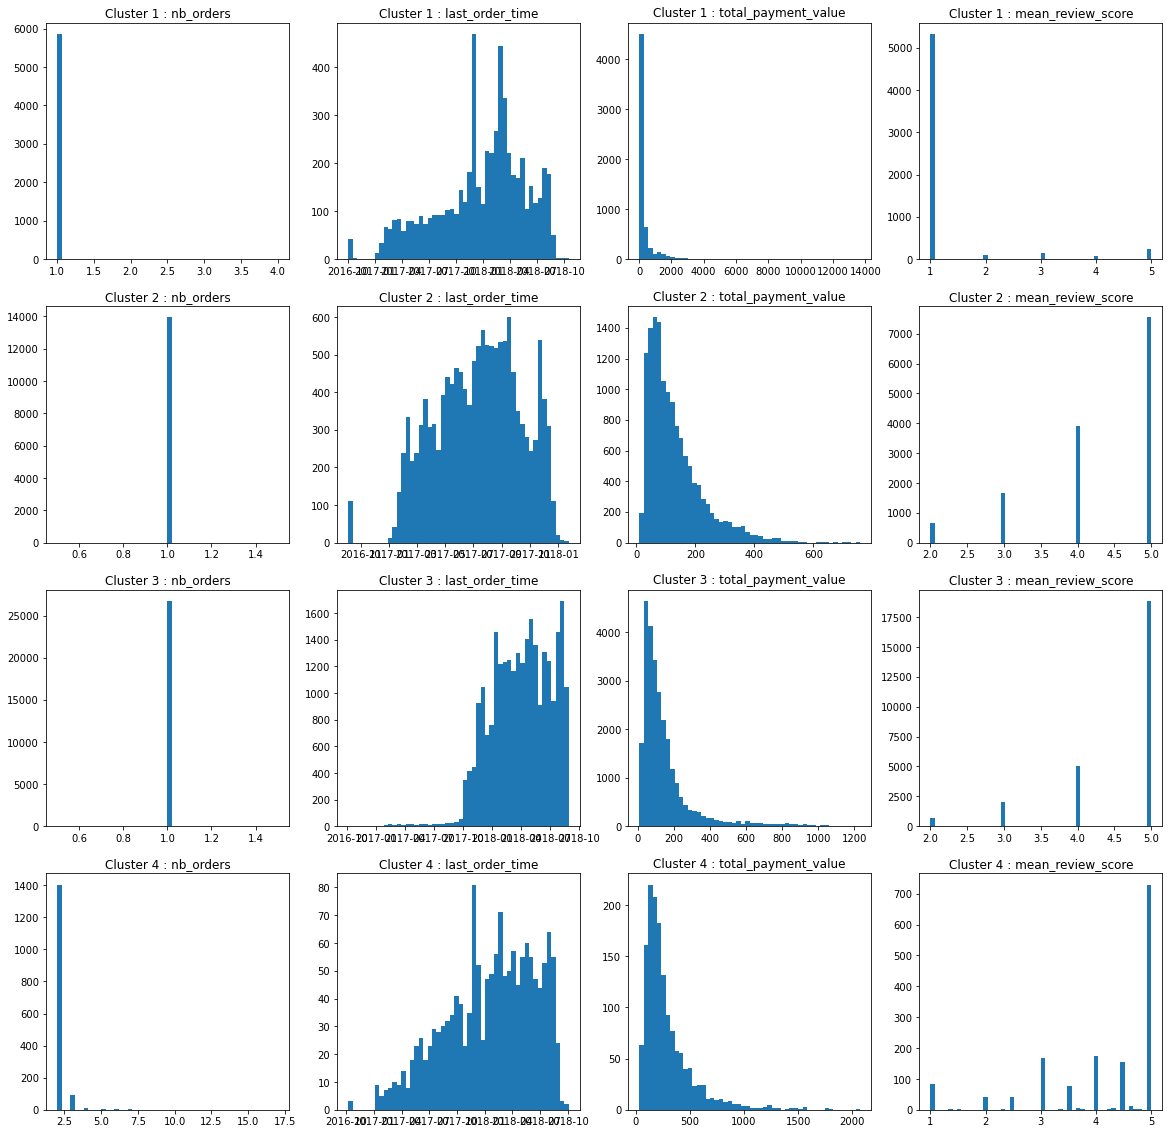

In [51]:
# Visualisation of distribution of variables for each cluster

plot_variables_distributions_clusters(selected_model, X_reduced_1)

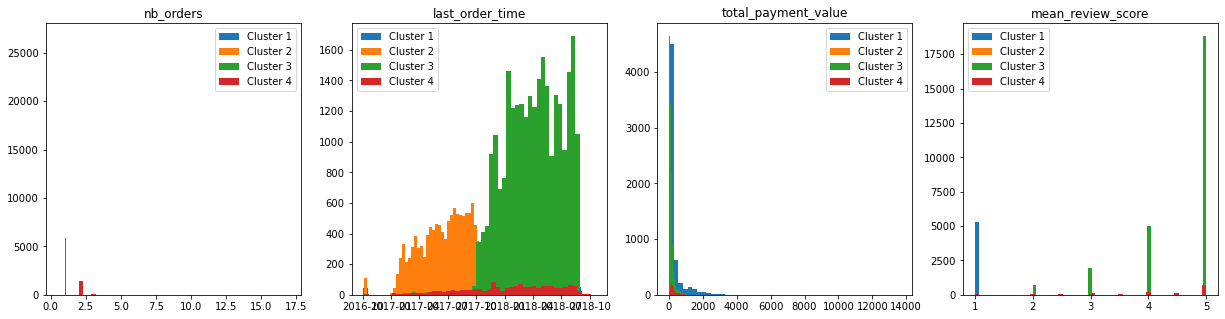

In [52]:
# Visualisation of distribution of variables per clusters on the same chart

plot_variables_aggregated_distributions_clusters(selected_model, X_reduced_1, figsize=(21,5))

Interpretation :
- Cluster 1 : Quite active customers / mostly one order / medium amount spent / low satisfaction
- Cluster 2 : Not recently active customers / only one order / low amount spent / high satisfaction
- Cluster 3 : Recently active customers / mostly one order / low amount spent / high satisfaction
- Cluster 4 : Recently active customers / several orders / medium amount spent / high satisfaction

# 6. Conclusion <a class="anchor" id="19-bullet"></a>

- The DBSCAN algortihm doesn't seem to do a good job so we won't use it
- The agglomerative clustering gives interesting results but I can't use it on the full dataset (lack of memory)
- KMeans gives good results and can be operated on the full dataset --> we will use this algorithm
- The most interesting results are with the variables 'nb_orders', 'last_order_time', 'total_payment_value' and 'mean_review_score', with 5 clusters